# Solving SDEs Numerically

In [1]:
import numpy as np
from typing import Callable
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib notebook

## Euler-Maruyama Method

In [2]:
def euler_maruyama(drift: Callable, diffusion: Callable, y0: np.ndarray, 
                   ti: float, tf: float, dt: float) -> np.ndarray:
    ts = np.arange(ti, tf + dt, dt)
    dW = ss.norm(loc=0, scale=np.sqrt(dt)).rvs(len(ts))
    ys = np.zeros((len(ts), *y0.shape))
    ys[0] = y0
    for i in range(len(ts)-1):
        ys[i + 1, :] = ys[i, :] + drift(ys[i, :], ts[i])*dt + diffusion(ys[i, :], ts[i]) * dW[i] 
    return ys, ts

## Runge-Kutta Method

In [24]:
def rk_sde(drift: Callable, diffusion: Callable, y0: np.ndarray, 
           ti: float, tf: float, dt: float) -> np.ndarray:
    ts = np.arange(ti, tf + dt, dt)
    dW = ss.norm(loc=0, scale=np.sqrt(dt)).rvs(len(ts))
    ys = np.zeros((len(ts), *y0.shape))
    ys[0] = y0
    for i in range(len(ts)-1):
        k1 = (drift(ys[i, :], ts[i])*dt + 
              (dW[i] - np.sign(dW[i])*np.sqrt(dt))*diffusion(ys[i, :], ts[i]))
        k2 = (drift(ys[i, :] + k1, ts[i+1])*dt + 
              (dW[i] + np.sign(dW[i])*np.sqrt(dt))*diffusion(ys[i, :] + k1, ts[i+1]))
        ys[i + 1, :] = ys[i, :] + 0.5 * (k1 + k2)
    return ys, ts

## Problem setup

In [3]:
k = 500000  # Stiffness [N/m]
m = 50  # Rotor mass[kg]
r_u = 0.1  # Eccentricity [m]
m_u = 0.05  # Unbalanced mass [kg]
c = 200  # Damping coefficient [Ns/m]
ti = 0  # Initial time [s] 
tf = 2  # Final time [s] (originally 5s)
fs = 1E6 # Sampling rate
Nt = fs*(tf-ti)  # Time steps Originall 4096 for 5 seconds 
slew_rate = 200 # RPM slew rate [rpm/s]
dt = 1/fs

A = np.array([[0, 1], [-k/m, -c/m]])

X0 = np.array([[0], [0]]); # Rewrite second order DE as first -> X = [x; dx/dt] 

# Prescribed angular vel -> sinusoidal with amplitude of 5rad/s and freq of
# 1Hz, offset of 100 rad/s
omega = lambda t: 10 + 5*np.sin(2*np.pi*1*t);

# Forcing function f(t)
f = lambda t: m_u * r_u * omega(t)**2 * np.sum(np.sin(np.arange(1,5) * omega(t)), 0)
                                              
# EoM -> dX = F(t,X)dt + G(t,X)dW
F = lambda X, t: np.dot(A, X) + np.array([[0], [f(t)/m]])  #  Drift
G = lambda X, t: np.array([[0], [1]])/1E3  # Diffusion

# EoM =lambda: X, t: np.dot(A, X) + np.array([zeros(size(t)); f(t)/m]

## Plot Euler-Maruyama Method

<IPython.core.display.Javascript object>


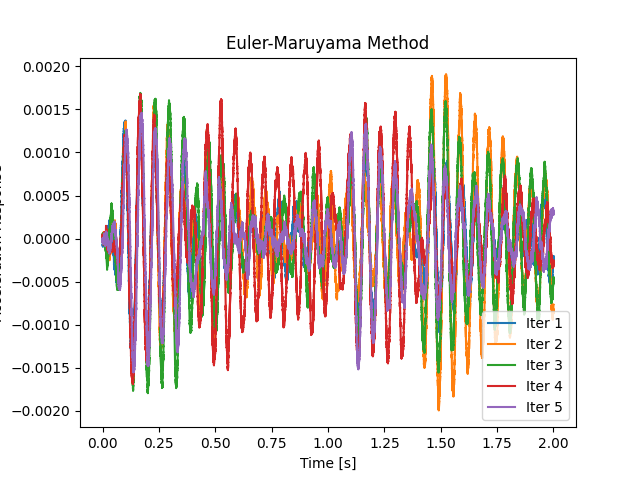

In [12]:
plt.figure()
for j in range(5):
    y, t = euler_maruyama(drift=F, diffusion=G, y0=X0, ti=ti, tf=tf, dt=dt)
    plt.plot(t, y[:, 1, :], label=f"Iter {j+1}")
plt.legend()
plt.title("Euler-Maruyama Method")
plt.xlabel("Time [s]")
plt.ylabel("Acceleration Response")
plt.show()

### Effect of timestep size

<IPython.core.display.Javascript object>


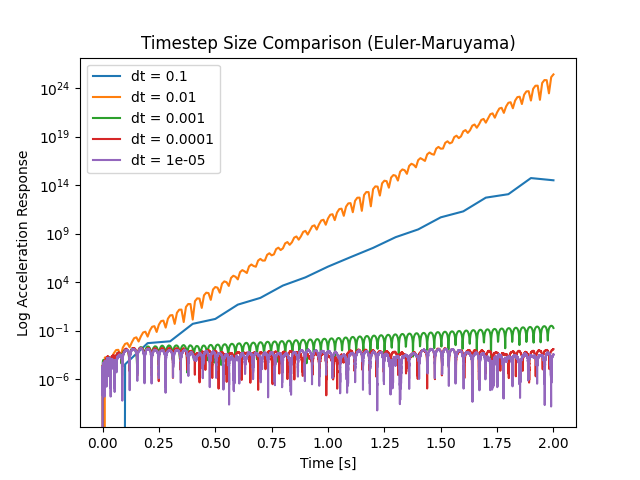

In [22]:
plt.figure()
for j in range(5):
    dtj = 10**-(j+1)
    y, t = euler_maruyama(drift=F, diffusion=G, y0=X0, ti=ti, tf=2, dt=dtj)

    plt.semilogy(t, np.abs(y[:, 1, :]), label=f"dt = {dtj}")
    
plt.legend()
# plt.ylim((-0.004, 0.004))
plt.title("Timestep Size Comparison (Euler-Maruyama)")
plt.xlabel("Time [s]")
plt.ylabel("Log Acceleration Response")
plt.show()

## Plot Runge Kutta SDE

<IPython.core.display.Javascript object>


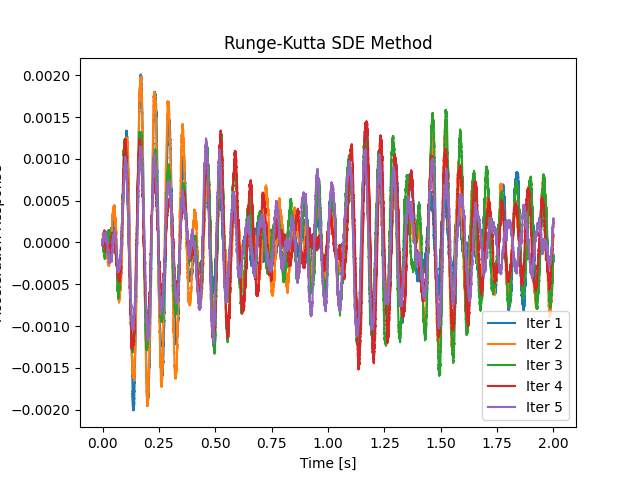

In [25]:
plt.figure()
for j in range(5):
    y, t = rk_sde(drift=F, diffusion=G, y0=X0, ti=ti, tf=tf, dt=1E-5)
    plt.plot(t, y[:, 1, :], label=f"Iter {j+1}")
plt.legend()
plt.title("Runge-Kutta SDE Method")
plt.xlabel("Time [s]")
plt.ylabel("Acceleration Response")
plt.show()

### Effect of timestep size

<IPython.core.display.Javascript object>


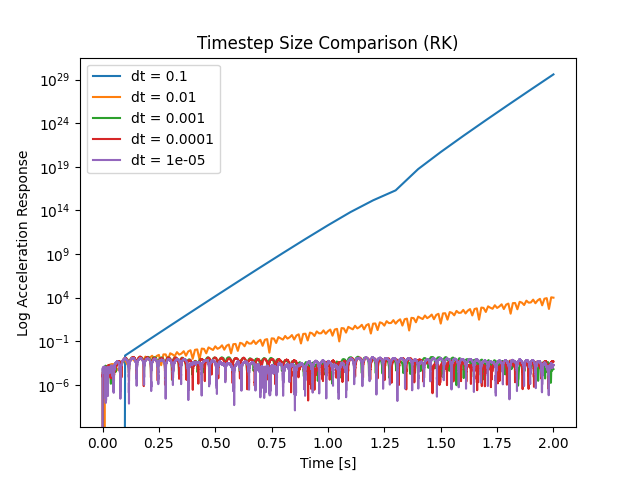

In [26]:
plt.figure()
for j in range(5):
    dtj = 10**-(j+1)
    y, t = rk_sde(drift=F, diffusion=G, y0=X0, ti=ti, tf=2, dt=dtj)

    plt.semilogy(t, np.abs(y[:, 1, :]), label=f"dt = {dtj}")
    
plt.legend()
# plt.ylim((-0.004, 0.004))
plt.title("Timestep Size Comparison (RK)")
plt.xlabel("Time [s]")
plt.ylabel("Log Acceleration Response")
plt.show()